In [2]:
import scanpy as sc
import anndata as ann
import numpy as np 
import seaborn as sb
import pandas as pd
import pickle
from sklearn import preprocessing as pp
import diffxpy.api as de
import time
from scipy import sparse

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/mm_pancreas_atlas_rep/code/')
from importlib import reload  
import helper
reload(helper)
import helper as h
from constants import SAVE
import expected_multiplet_rate as emr
reload(emr)
import expected_multiplet_rate as emr
#sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
%%R
library(scran)
library(biomaRt)
library(BiocParallel)
#library(Seurat)

In [5]:
# Path for saving results - last shared folder by all datasets
shared_folder='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/'
UID2='STZ_nonref_annotation'

Load data:

In [6]:
#Load data
#adata=pickle.load(  open( shared_folder+"data_normalised.pkl", "rb" ) )
adata=h.open_h5ad(shared_folder+"data_normalised.h5ad",unique_id2=UID2)

## Add previously generated annotation

In [6]:
# Add previously generated annotation 
#adata_preannotated=h.open_h5ad("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/maren/data_endo_final.h5ad",unique_id2=UID2)
adata_preannotated=h.open_h5ad("/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_glpest_lickert/rev7/subarna_study/GSE128565_adata_processed.h5ad.h5",unique_id2=UID2)

In [7]:
adata_preannotated

AnnData object with n_obs × n_vars = 32888 × 18210
    obs: 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'groups', 'treatment', 'groups_named_broad', 'S_score', 'G2M_score', 'phase', 'proliferation', 'proliferation_man', 'doublet_score', 'groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst', 'groups_named_broad_cond'
    var: 'n_cells', 'highly_variable_genes'
    uns: 'groups_named_beta_dpt_colors', 'groups_named_broad_colors', 'groups_named_fine_colors', 'proliferation_colors', 'proliferation_man_colors', 'rank_genes_groups', 'treatment_colors', 'treatment_colors_rgb'
    obsm: 'X_umap'

In [8]:
# Subset preannotated dataset obs and order it to match current dataset
preannotated_obs=adata_preannotated.obs.copy()
preannotated_obs=preannotated_obs.reindex([idx.replace('-'+adata.obs.at[idx,'file'],'_'+adata.obs.at[idx,'file']) for idx in adata.obs.index])

In [9]:
# Add pre-prepared cell type annotation to currently used dataset
# Add 'pre_' before each original annotation
for annotation in ['groups_named_broad','groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst']:
    annotation_new='pre_'+annotation
    # Data was sorted before - remove index as they do not match
    adata.obs[annotation_new]=preannotated_obs[annotation].values
    # Replace np.nan with na
    adata.obs[annotation_new] = adata.obs[annotation_new].cat.add_categories('NA')
    adata.obs[annotation_new].fillna('NA', inplace =True) 
    # Remove unused categories
    adata.obs[annotation_new].cat.remove_unused_categories(inplace=True)

Pre-annotated cell type count

In [10]:
# Count of cells per annotation
for annotation in ['groups_named_broad','groups_named_fine', 'groups_named_beta_dpt', 'Ins-Gcg-Sst']:
    # For some reason the same line above does not remove all categories, thus it is done here again
    adata.obs['pre_'+annotation].cat.remove_unused_categories(inplace=True)
    print('pre_'+annotation,':')
    print(adata.obs['pre_'+annotation].value_counts())

pre_groups_named_broad :
NA              17101
beta            12262
polyhormonal     6347
delta            6110
alpha            5963
PP               1762
Name: pre_groups_named_broad, dtype: int64
pre_groups_named_fine :
NA                      17101
Sst-Ppy_low              6110
Gcg                      5963
Ins_1                    5628
Ins_dedifferentiated     4118
Ins-Sst-Ppy              2951
Ins_2                    2516
Ins-Ppy                  1788
Ppy                      1762
Gcg-Ppy_high              862
Gcg-Ppy_low               624
Ins-Sst                   122
Name: pre_groups_named_fine, dtype: int64
pre_groups_named_beta_dpt :
NA                      17101
Sst-Ppy_low              6110
Gcg                      5963
Ins_1                    5480
Ins_dedifferentiated     4118
Ins-Sst-Ppy              2951
Ins_2                    2516
Ins-Ppy                  1788
Ppy                      1762
Gcg-Ppy_high              862
Gcg-Ppy_low               624
Ins_3           

In [11]:
# Set one annotation column to pre_cell_type to enable below code to work
adata.obs.rename(columns={'pre_groups_named_beta_dpt':'pre_cell_type'}, inplace=True)

## Visualisation

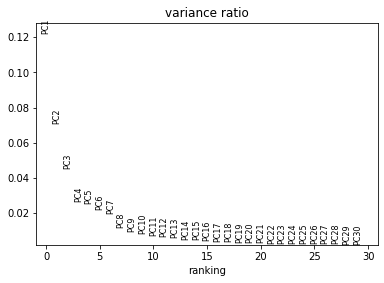

In [7]:
sc.pp.pca(adata, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata)

In [8]:
# Select number of PCs to use
N_PCS=15

Compare different embeddings based on previously defined annotation. 

In [9]:
#sc.pp.neighbors(adata,n_pcs = N_PCS,metric='correlation') 
#sc.tl.umap(adata)

In [10]:
#rcParams['figure.figsize']=(7,7)
#sc.pl.umap(adata,size=10,color=['pre_cell_type'])
#sc.pl.umap(adata,size=10,color=['file'])

In [11]:
sc.pp.neighbors(adata,n_pcs = N_PCS) 
sc.tl.umap(adata)

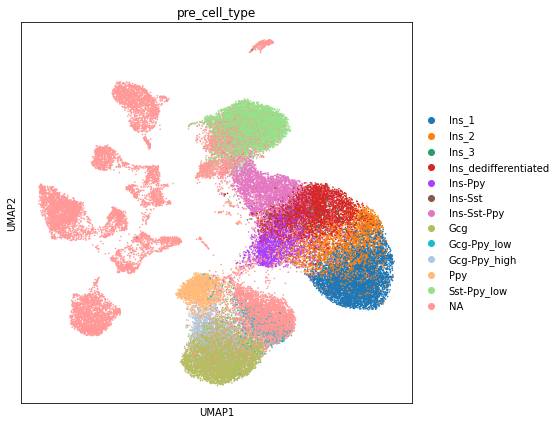

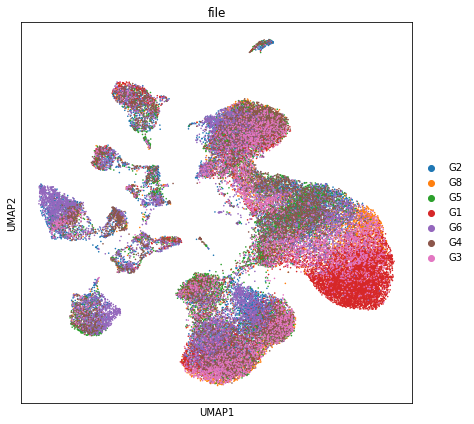

In [17]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata,size=10,color=['pre_cell_type'])
sc.pl.umap(adata,size=10,color=['file'])

#### On scaled data

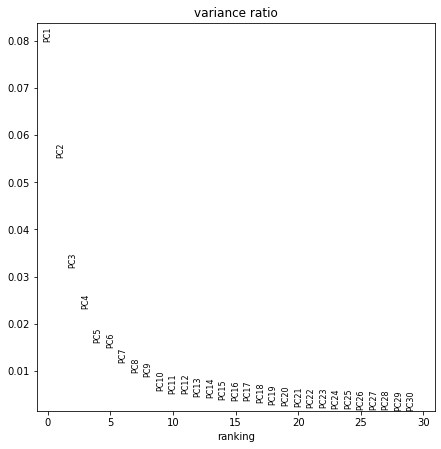

In [18]:
# Scale data and perform PCA
adata_scl=adata.copy()
sc.pp.scale(adata_scl,max_value=10)
sc.pp.pca(adata_scl, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_scl)

In [19]:
#C: Can not stay the same as above
N_PCS

15

In [19]:
# neighbours on scaled data
sc.pp.neighbors(adata_scl,n_pcs = 18) 

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [20]:
# Umap on scaled data
sc.tl.umap(adata_scl)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


In [21]:
# Add scaled embedding to adata
adata.obsm['X_umap_scl']=adata_scl.obsm['X_umap']

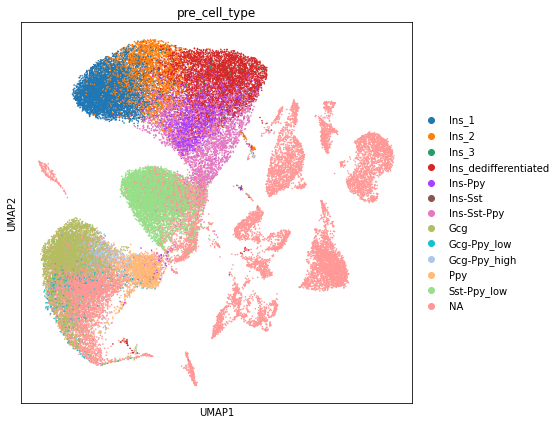

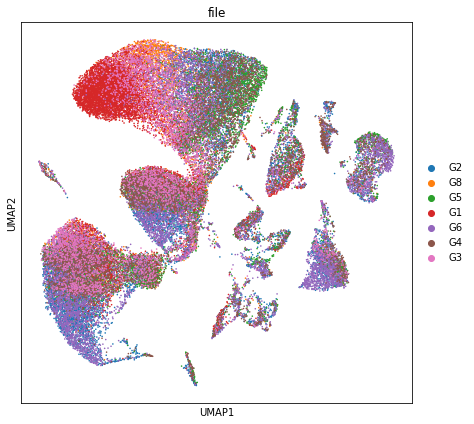

In [22]:
rcParams['figure.figsize']=(7,7)
sc.pl.umap(adata_scl,size=10,color=['pre_cell_type'])
sc.pl.umap(adata_scl,size=10,color=['file'])

## Cell cycle
Performed separately for individual batches.

### Seurat/Scanpy - score by G2M and S

In [23]:
# Load mouse cell cycle genes
cell_cycle_mm=pd.read_table('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/cell_cycle_mm_Macosko2015.tsv',sep='\t')

Use cell cycle genes that overlap HVGs (from different batches). Display these genes on HVG plots (with non-phase genes being marked as .NA).

Use G2/M and M gene sets for G2/M annotation and S gene set for S annotation.

G1/S N genes: 92 overlap var: 90 overlap hvg (all): 4
S N genes: 96 overlap var: 95 overlap hvg (all): 7
G2/M N genes: 127 overlap var: 126 overlap hvg (all): 19
M N genes: 143 overlap var: 141 overlap hvg (all): 16
M/G1 N genes: 108 overlap var: 105 overlap hvg (all): 5
N genes for scoring S: 7 and G2/M: 35


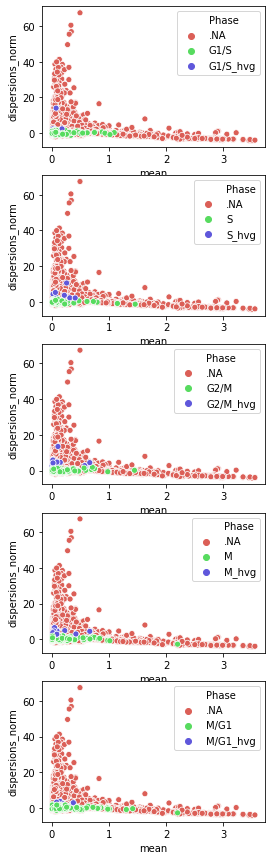

In [24]:
# How many of the cell cycle phase genes are present in HVG and in var and how variable they are
hvg=set(adata.var_names[adata.var.highly_variable])
i=0
rcParams['figure.figsize']=(4,15)
fig,axs=plt.subplots(5)
s_hvg=[]
g2m_hvg=[]
for phase in cell_cycle_mm.Phase.unique():
    genes_phase = set(cell_cycle_mm.query('Phase =="'+phase+'"').Gene)
    overlap_var = set(adata.var_names) & genes_phase
    overlap_hvg = hvg & genes_phase
    print(phase,'N genes:',len(genes_phase),'overlap var:',len(overlap_var),'overlap hvg (all):',len(overlap_hvg))
    phase_df=pd.DataFrame([phase]*len(overlap_var),index=overlap_var,columns=['Phase']).reindex(adata.var_names).fillna('.NA').sort_values('Phase')
    phase_df.loc[overlap_hvg,'Phase']=phase+'_hvg'
    phase_df['mean']=adata.var.means
    phase_df['dispersions_norm']=adata.var.dispersions_norm
    sb.scatterplot(x="mean", y="dispersions_norm", hue="Phase",data=phase_df,ax=axs[i],palette='hls')
    i+=1
    if phase == 'S':
        s_hvg.extend(overlap_hvg)
    if phase in ['G2/M','M']:
        g2m_hvg.extend(overlap_hvg)
        
print('N genes for scoring S:',len(s_hvg),'and G2/M:',len(g2m_hvg))

Cell cycle annotation

In [25]:
# Annotated cell cycle per batch
adata.obs['S_score']= np.zeros(adata.shape[0])
adata.obs['G2M_score'] = np.zeros(adata.shape[0])
adata.obs['phase'] = np.zeros(adata.shape[0])

for batch in enumerate(adata.obs['file'].cat.categories):
    batch=batch[1]
    idx = adata.obs.query('file=="'+batch+'"').index
    adata_tmp = adata[idx,:].copy()
    sc.tl.score_genes_cell_cycle(adata_tmp, s_genes=s_hvg, g2m_genes=g2m_hvg,use_raw=False)
    adata.obs.loc[idx,'S_score'] = adata_tmp.obs['S_score']
    adata.obs.loc[idx,'G2M_score'] = adata_tmp.obs['G2M_score']
    adata.obs.loc[idx,'phase'] = adata_tmp.obs['phase']
    
del adata_tmp

In [26]:
# Count of cells annotated to each phase
adata.obs['phase'].value_counts()

G1     24656
S      18787
G2M     6102
Name: phase, dtype: int64

Display cell cycle score distributions and annotation.

... storing 'phase' as categorical


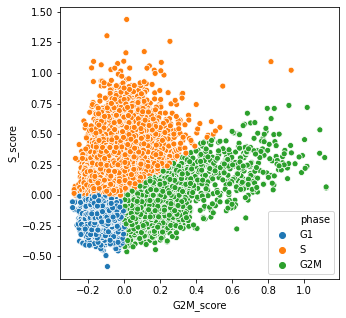

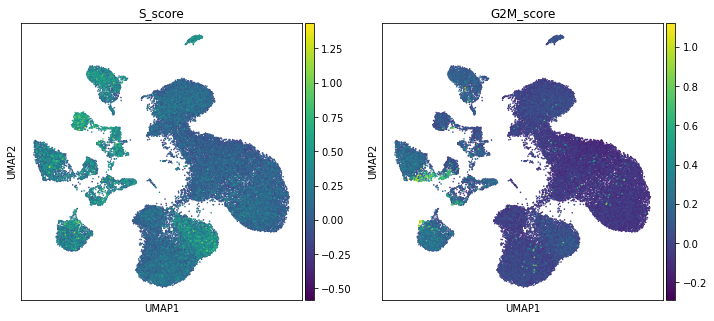

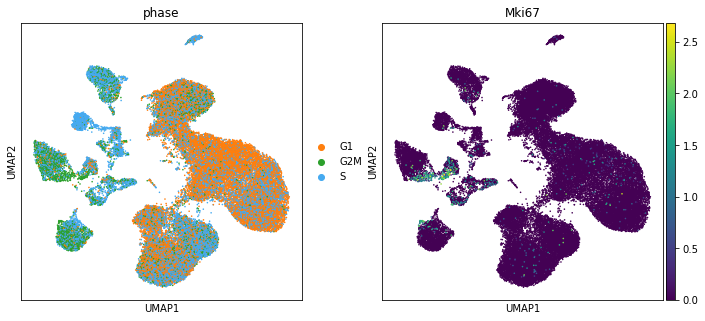

In [27]:
adata.uns['phase_colors']=['#ff7f0e', '#2ca02c','#46aaf0']

rcParams['figure.figsize']=(5,5)
sb.scatterplot(x='G2M_score',y='S_score',hue='phase',data=adata.obs)
sc.pl.umap(adata, color=['S_score', 'G2M_score'], size=10, use_raw=False)
sc.pl.umap(adata, color=['phase','Mki67'], size=10, use_raw=False)

#C: There might be some proliferating populations, but it is not very clear as many cells that probably are not proliferating (low Mki67 expression - not G2M) are annotated as cycling / G2M.

 ### Cyclone - based on G1, S, and G2/M scores

Add gene Entrez IDs to adata in order to map genes to cell cycle database.

In [28]:
# Adata genes for R
genes=adata.var_names

#C: Current Ensembl release 101

In [29]:
%%R -i genes -o gene_ids
# Extract Ensembl gene IDs
mouse = useMart("ENSEMBL_MART_ENSEMBL", dataset = "mmusculus_gene_ensembl",version='Ensembl Genes 101',
                host="https://www.ensembl.org")
gene_ids = getBM(attributes = c("mgi_symbol",'ensembl_gene_id'), 
                 filters = "mgi_symbol", values = genes , mart = mouse, uniqueRows=FALSE)

In [30]:
# Add gene ids to adata, use only genes with unique mapped ensembl ids
gene_ids.drop_duplicates(subset='mgi_symbol', keep=False, inplace=True)
gene_ids.index=gene_ids.mgi_symbol
gene_ids=gene_ids.reindex(list(adata.var_names))
adata.var['EID']=gene_ids.ensembl_gene_id

In [31]:
# Prepare R data for cyclonee
x_mat=adata.X.T
gene_ids=adata.var.EID
batches=adata.obs.file
cells=adata.obs.index

In [32]:
%%R -i x_mat -i gene_ids -i batches -i cells -o cyclone_anno
# Cyclone cell scores, calculated separately for each batch
mm.pairs <- readRDS(system.file("exdata", "mouse_cycle_markers.rds", package="scran"))
phases<-c()
s<-c()
g2m<-c()
g1<-c()
cells_order<-c()
for(batch in unique(batches)){
    # Select batch data
    x_mat_batch=x_mat[,batches==batch]
    print(batch,dim(x_mat_batch[1]))
    # Scores
    assignments <- cyclone(x_mat_batch, mm.pairs, gene.names=gene_ids,BPPARAM=MulticoreParam(workers = 16))
    phases<-c(phases,assignments$phases)
    s<-c(s,assignments$score$S)
    g2m<-c(g2m,assignments$score$G2M)
    g1<-c(g1,assignments$score$G1)
    # Save cell order
    cells_order<-c(cells_order,cells[batches==batch])
}
cyclone_anno<-data.frame(phase_cyclone=phases,s_cyclone=s,g2m_cyclone=g2m,g1_cyclone=g1)
rownames(cyclone_anno)<-cells_order

[1] "G2"
[1] "G8"
[1] "G5"
[1] "G1"
[1] "G6"
[1] "G4"
[1] "G3"


In [33]:
# Count of cells annotated to each phase
cyclone_anno.phase_cyclone.value_counts()

G1     48735
G2M      575
S        235
Name: phase_cyclone, dtype: int64

In [34]:
# Add cyclone annotation to adata
cyclone_anno=cyclone_anno.reindex(adata.obs.index)
adata.obs=pd.concat([adata.obs,cyclone_anno],axis=1)

... storing 'phase_cyclone' as categorical
... storing 'EID' as categorical


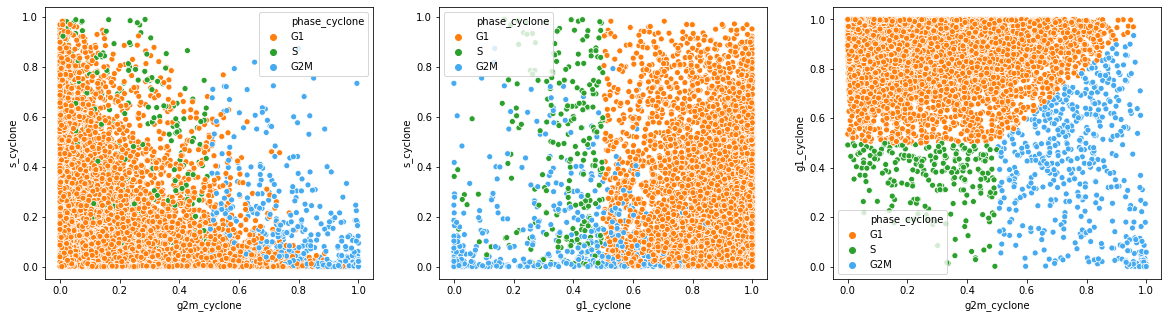

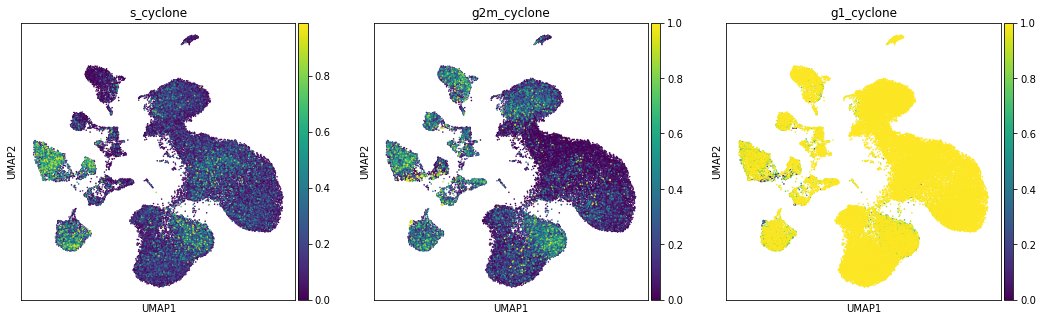

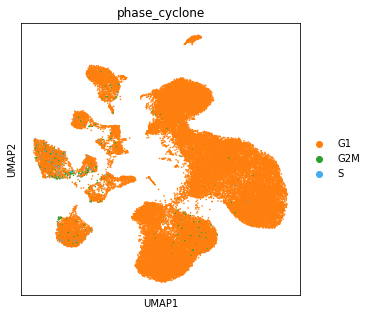

In [35]:
# Plot score distributions and cell assignment on UMAP
rcParams['figure.figsize']=(20,5)
fig,axs=plt.subplots(1,3)
palette=sb.color_palette(['#ff7f0e', '#2ca02c','#46aaf0'])
sb.scatterplot(x='g2m_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[0],palette=palette)
sb.scatterplot(x='g1_cyclone',y='s_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[1],palette=palette)
sb.scatterplot(x='g2m_cyclone',y='g1_cyclone',hue='phase_cyclone',data=cyclone_anno,ax=axs[2],palette=palette)
rcParams['figure.figsize']=(5,5)
sc.pl.umap(adata, color=['s_cyclone', 'g2m_cyclone','g1_cyclone'], size=10, use_raw=False)
adata.uns['phase_cyclone_colors']=['#ff7f0e', '#2ca02c','#46aaf0']
sc.pl.umap(adata, color=['phase_cyclone'], size=10, use_raw=False)

#C: The cyclone results seem more reliable based on Mki67 expression (above) and embedding.

Check previous annotation results

In [36]:
for annotation in ['S_score', 'G2M_score', 'phase', 'proliferation', 'proliferation_man']:
    annotation_new='pre_'+annotation
    # Data was sorted before - remove index as they do not match
    adata.obs[annotation_new]=preannotated_obs[annotation].values
    # Replace np.nan with 'NA' if it is categorical
    if adata.obs[annotation_new].dtype.name=='category':
        adata.obs[annotation_new] = adata.obs[annotation_new].cat.add_categories('NA')
        adata.obs[annotation_new].fillna('NA', inplace =True) 
        # Remove unused categories
        adata.obs[annotation_new].cat.remove_unused_categories(inplace=True)

In [37]:
adata.obs.columns

Index(['file', 'n_counts', 'n_genes', 'mt_frac', 'n_counts_filter',
       'n_genes_filter', 'mt_frac_filter', 'doublet_score', 'doublet',
       'doublet_score_filter', 'size_factors', 'pre_groups_named_broad',
       'pre_groups_named_fine', 'pre_cell_type', 'pre_Ins-Gcg-Sst', 'S_score',
       'G2M_score', 'phase', 'phase_cyclone', 's_cyclone', 'g2m_cyclone',
       'g1_cyclone', 'pre_S_score', 'pre_G2M_score', 'pre_phase',
       'pre_proliferation', 'pre_proliferation_man'],
      dtype='object')

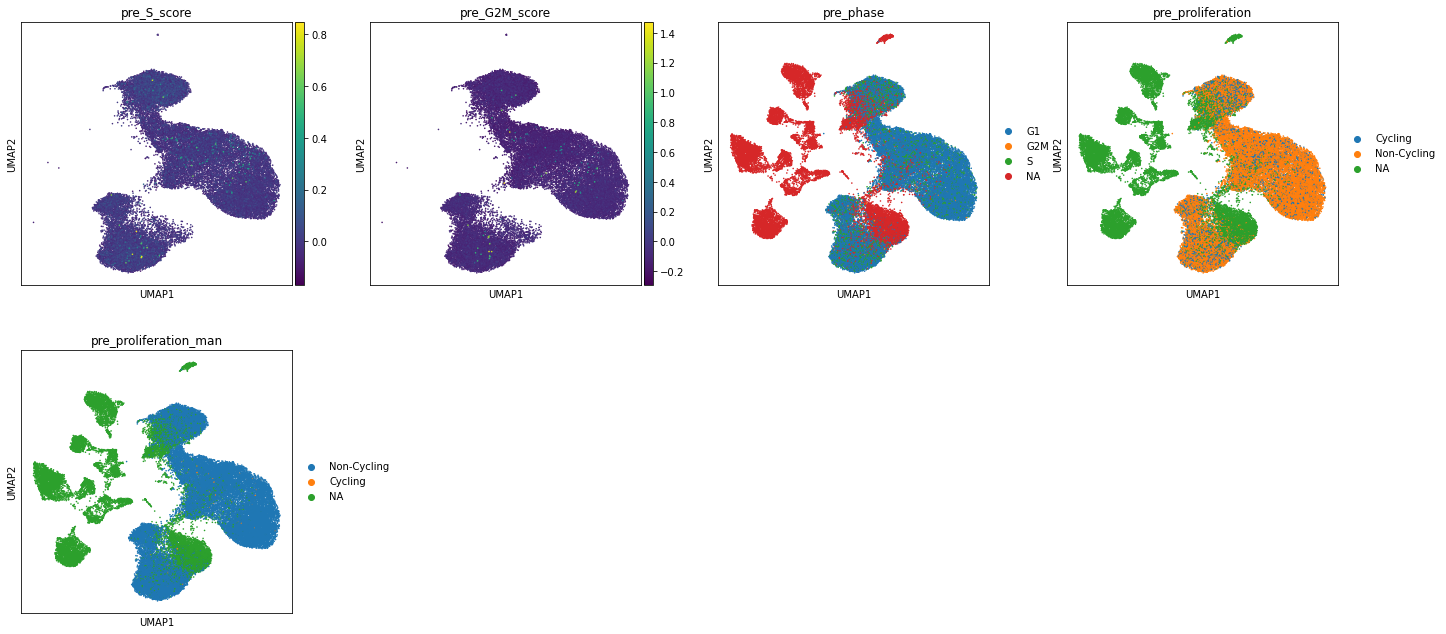

In [38]:
# Non-categorical variables do not show np.nan cells
sc.pl.umap(adata, color=['pre_S_score', 'pre_G2M_score', 'pre_phase',
       'pre_proliferation', 'pre_proliferation_man'], size=10, use_raw=False)

#C: cyclone annotation matches more previous manual (? - man?) annotation.

## Save intermediate results before cell type annotation

In [42]:
if SAVE:
    h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)

# Cell type annotation

In [5]:
adata=h.open_h5ad(shared_folder+"data_annotated.h5ad",unique_id2=UID2)

## Endo high annotation

In [6]:
# Normalise raw data for cell type scoring
adata_rawnorm=adata.raw.to_adata().copy()
adata_rawnorm.X /= adata.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata_rawnorm)
adata_rawnorm.X = np.asarray(adata_rawnorm.X)
adata_rawnorm.obs=adata.obs.copy()

#### Ins

In [7]:
# Compute Ins score
sc.tl.score_genes(adata_rawnorm, gene_list=['Ins1','Ins2'], score_name='ins_score',  use_raw=False)

<ipython-input-12-cab345d1d34c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ins_scores['ins_score_norm']=pp.minmax_scale(ins_scores.ins_score)


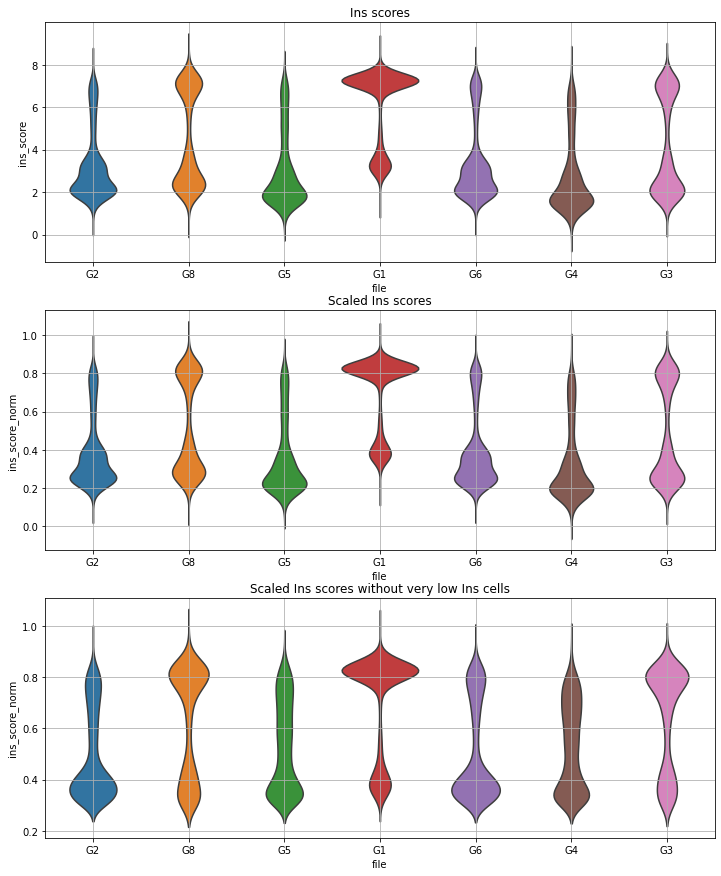

In [12]:
#sc.pl.violin(adata_rawnorm, keys=['ins_score'], groupby='file', stripplot=False, jitter=True)
ins_scores=adata_rawnorm.obs[['ins_score','file']]
ins_scores['ins_score_norm']=pp.minmax_scale(ins_scores.ins_score)
rcParams['figure.figsize']=(12,15)
fig,axs=plt.subplots(3,1)
sb.violinplot(x='file',y='ins_score',data=ins_scores,inner=None,ax=axs[0])
axs[0].title.set_text('Ins scores')
axs[0].grid()
sb.violinplot(x='file',y='ins_score_norm',data=ins_scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled Ins scores')
axs[1].grid()
sb.violinplot(x='file',y='ins_score_norm',data=ins_scores[ins_scores.ins_score_norm>0.3],inner=None,ax=axs[2])
axs[2].title.set_text('Scaled Ins scores without very low Ins cells')
axs[2].grid()

In [14]:
# Find ins high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'G2':0.55,'G8':0.6,'G5':0.5,'G1':0.65,'G6':0.55,'G4':0.5,'G3':0.55}
adata_rawnorm.obs['ins_high']=ins_scores.apply(lambda x: x.ins_score_norm > file_thresholds[x.file], axis=1)
print('Proportion of ins high across samples:')
adata_rawnorm.obs[['file','ins_high']].groupby('file').ins_high.value_counts(normalize=True,sort=False)

Proportion of ins high across samples:


file  ins_high
G2    False       0.814242
      True        0.185758
G8    False       0.589821
      True        0.410179
G5    False       0.775824
      True        0.224176
G1    False       0.290653
      True        0.709347
G6    False       0.796816
      True        0.203184
G4    False       0.796408
      True        0.203592
G3    False       0.604959
      True        0.395041
Name: ins_high, dtype: float64

In [15]:
# Add info about ins high to main adata and save it
adata.obs['ins_score']=adata_rawnorm.obs['ins_score']
adata.obs['ins_high']=adata_rawnorm.obs['ins_high']

#### Gcg

In [7]:
genes=['Gcg']
score_name='gcg'

In [8]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name+'_score',  use_raw=False)

<ipython-input-9-458a9266293c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])


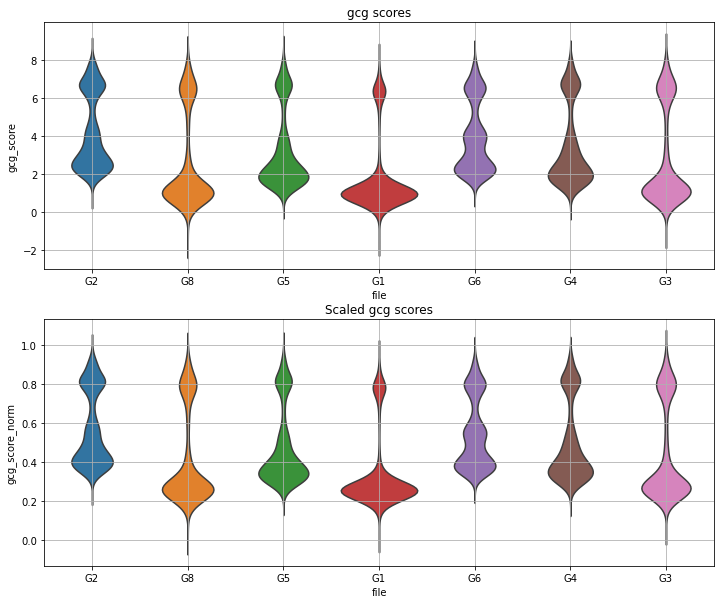

In [9]:
scores=adata_rawnorm.obs[[score_name+'_score','file']]
scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])
rcParams['figure.figsize']=(12,10)
fig,axs=plt.subplots(2,1)
sb.violinplot(x='file',y=score_name+'_score',data=scores,inner=None,ax=axs[0])
axs[0].title.set_text(score_name+' scores')
axs[0].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled '+score_name+' scores')
axs[1].grid()
#sb.violinplot(x='file',y=score_name+'_score_norm',data=scores[scores[score_name+'_score_norm']>0.15],
#             inner=None,ax=axs[2])
#axs[2].title.set_text('Scaled '+score_name+' scores without very low '+score_name+' cells')
#axs[2].grid()

In [10]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'G2':0.7,'G8':0.6,'G5':0.65,'G1':0.6,'G6':0.7,'G4':0.7,'G3':0.6}
adata_rawnorm.obs[score_name+'_high']=scores.apply(lambda x: x[score_name+'_score_norm'] > file_thresholds[x.file], 
                                                   axis=1)
print('Proportion of '+score_name+' high across samples:')
adata_rawnorm.obs[['file',score_name+'_high']].groupby('file')[score_name+'_high'].value_counts(
    normalize=True,sort=False)

Proportion of gcg high across samples:


file  gcg_high
G2    False       0.674760
      True        0.325240
G8    False       0.729723
      True        0.270277
G5    False       0.781731
      True        0.218269
G1    False       0.855746
      True        0.144254
G6    False       0.740241
      True        0.259759
G4    False       0.756834
      True        0.243166
G3    False       0.700118
      True        0.299882
Name: gcg_high, dtype: float64

In [11]:
# Add info about score high to main adata and save it
adata.obs[score_name+'_score']=adata_rawnorm.obs[score_name+'_score']
adata.obs[score_name+'_high']=adata_rawnorm.obs[score_name+'_high']

#### SSt

In [12]:
genes=['Sst']
score_name='sst'

In [13]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name+'_score',  use_raw=False)

<ipython-input-14-458a9266293c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])


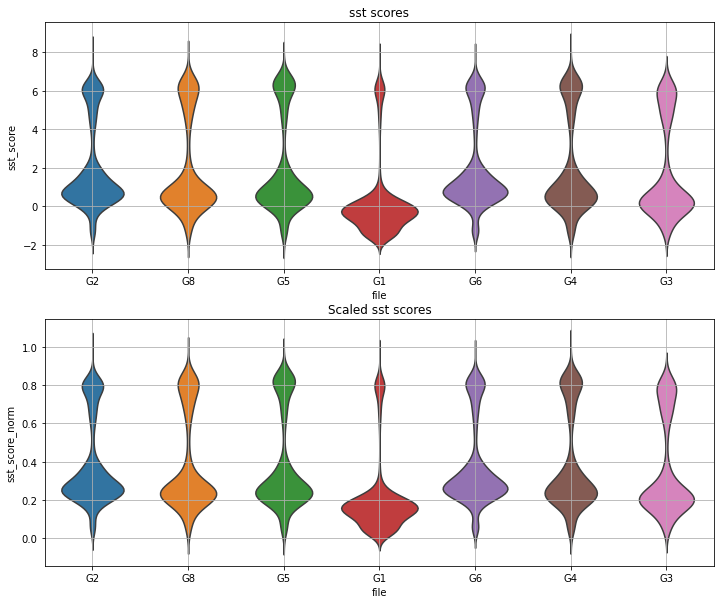

In [14]:
scores=adata_rawnorm.obs[[score_name+'_score','file']]
scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])
rcParams['figure.figsize']=(12,10)
fig,axs=plt.subplots(2,1)
sb.violinplot(x='file',y=score_name+'_score',data=scores,inner=None,ax=axs[0])
axs[0].title.set_text(score_name+' scores')
axs[0].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled '+score_name+' scores')
axs[1].grid()
#sb.violinplot(x='file',y=score_name+'_score_norm',data=scores[scores[score_name+'_score_norm']>0.15],
#             inner=None,ax=axs[2])
#axs[2].title.set_text('Scaled '+score_name+' scores without very low '+score_name+' cells')
#axs[2].grid()

In [15]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'G2':0.5,'G8':0.5,'G5':0.5,'G1':0.55,'G6':0.5,'G4':0.5,'G3':0.5}
adata_rawnorm.obs[score_name+'_high']=scores.apply(lambda x: x[score_name+'_score_norm'] > file_thresholds[x.file], 
                                                   axis=1)
print('Proportion of '+score_name+' high across samples:')
adata_rawnorm.obs[['file',score_name+'_high']].groupby('file')[score_name+'_high'].value_counts(
    normalize=True,sort=False)

Proportion of sst high across samples:


file  sst_high
G2    False       0.747387
      True        0.252613
G8    False       0.707181
      True        0.292819
G5    False       0.728709
      True        0.271291
G1    False       0.899738
      True        0.100262
G6    False       0.771875
      True        0.228125
G4    False       0.712015
      True        0.287985
G3    False       0.707202
      True        0.292798
Name: sst_high, dtype: float64

In [16]:
# Add info about score high to main adata and save it
adata.obs[score_name+'_score']=adata_rawnorm.obs[score_name+'_score']
adata.obs[score_name+'_high']=adata_rawnorm.obs[score_name+'_high']

#### Ppy

In [17]:
genes=['Ppy']
score_name='ppy'

In [18]:
# Compute score
sc.tl.score_genes(adata_rawnorm, gene_list=genes, score_name=score_name+'_score',  use_raw=False)

<ipython-input-20-2b5c4e20aae6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])


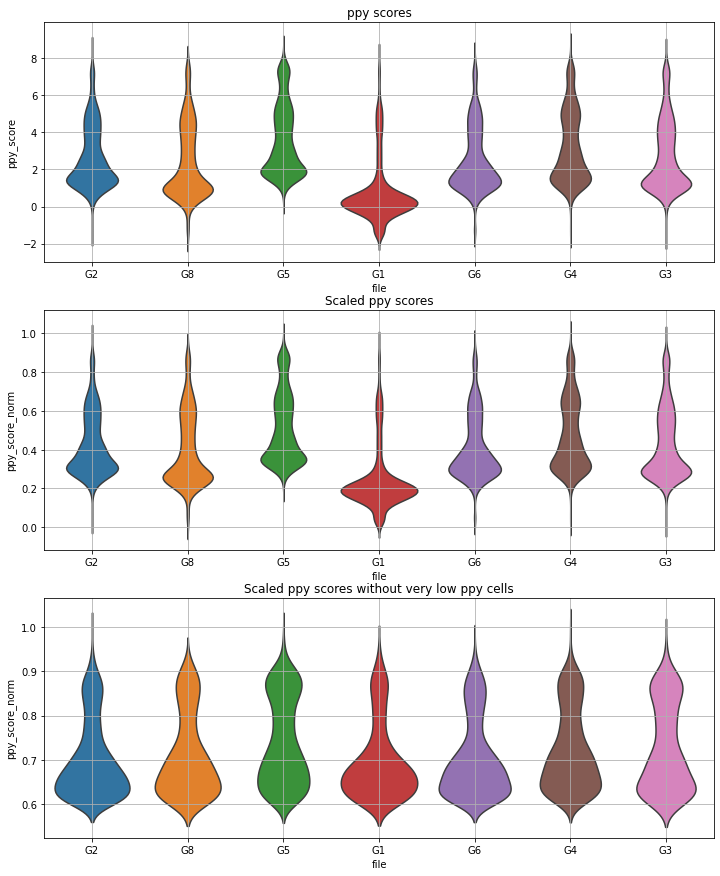

In [20]:
scores=adata_rawnorm.obs[[score_name+'_score','file']]
scores[score_name+'_score_norm']=pp.minmax_scale(scores[score_name+'_score'])
rcParams['figure.figsize']=(12,15)
fig,axs=plt.subplots(3,1)
sb.violinplot(x='file',y=score_name+'_score',data=scores,inner=None,ax=axs[0])
axs[0].title.set_text(score_name+' scores')
axs[0].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores,inner=None,ax=axs[1])
axs[1].title.set_text('Scaled '+score_name+' scores')
axs[1].grid()
sb.violinplot(x='file',y=score_name+'_score_norm',data=scores[scores[score_name+'_score_norm']>0.6],
             inner=None,ax=axs[2])
axs[2].title.set_text('Scaled '+score_name+' scores without very low '+score_name+' cells')
axs[2].grid()

In [21]:
# Find score high cells
# Use different thresholds across files as there might be different ambient counts (or other effects), 
# thus shifting distributions up a bit
file_thresholds={'G2':0.8,'G8':0.8,'G5':0.8,'G1':0.8,'G6':0.77,'G4':0.8,'G3':0.77}
adata_rawnorm.obs[score_name+'_high']=scores.apply(lambda x: x[score_name+'_score_norm'] > file_thresholds[x.file], 
                                                   axis=1)
print('Proportion of '+score_name+' high across samples:')
adata_rawnorm.obs[['file',score_name+'_high']].groupby('file')[score_name+'_high'].value_counts(
    normalize=True,sort=False)

Proportion of ppy high across samples:


file  ppy_high
G2    False       0.968097
      True        0.031903
G8    False       0.958866
      True        0.041134
G5    False       0.893544
      True        0.106456
G1    False       0.988197
      True        0.011803
G6    False       0.960864
      True        0.039136
G4    False       0.932295
      True        0.067705
G3    False       0.931759
      True        0.068241
Name: ppy_high, dtype: float64

In [22]:
# Add info about score high to main adata and save it
adata.obs[score_name+'_score']=adata_rawnorm.obs[score_name+'_score']
adata.obs[score_name+'_high']=adata_rawnorm.obs[score_name+'_high']

#### Save

In [25]:
if SAVE:
    h.save_h5ad(adata, shared_folder+"data_annotated.h5ad",unique_id2=UID2)